## Automated anisotropic resistivity inversion for efficient formation evaluation and uncertainty quantification

### Misael M. Morales, Ali Eghbali, Oriyomi Raheem, Michael Pyrcz, Carlos Torres-Verdin
***
## Compare Gradient-Based and PINN Results
***

In [1]:
from main import *

check_torch()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
case1, case2, synthetic1, synthetic2 = load_all_data()


------------------------------------------------------------
----------------------- VERSION INFO -----------------------
Torch version: 2.6.0+cu124 | Torch Built with CUDA? True
# Device(s) available: 1, Name(s): NVIDIA GeForce RTX 3090
------------------------------------------------------------

Name              : Source                : Shape
----------------- : --------------------- : -----------
Field Case 1      : (North Africa)        : (2399, 12)
Field Case 2      : (North Sea)           : (11143, 12)
Synthetic Case 1  : (Laminated)           : (801, 14)
Synthetic Case 2  : (Laminated+Dispersed) : (415, 10)


In [2]:
class ResInvPINN(nn.Module):
    def __init__(self, hidden_dim:int=128, csh_constraint_mult=1.0):
        super(ResInvPINN, self).__init__()
        self.fc1  = nn.Linear(2, hidden_dim)
        self.fc2  = nn.Linear(hidden_dim, hidden_dim)
        self.fc3  = nn.Linear(hidden_dim, 2)
        self.mult = csh_constraint_mult

    def constraints(self, d):
        c, s = d[:, 0], d[:, 1]
        c = self.mult*torch.sigmoid(c)
        return torch.stack([c, s], dim=-1)
       
    def forward(self, x):
        x = x[:, :2]
        
        x = self.fc1(x)
        x = nn.Tanh()(x)

        x = self.fc2(x)
        x = nn.Tanhshrink()(x)

        x = self.fc3(x)
        x = self.constraints(x)

        return x

In [3]:
field1_model      = ResInvPINN(hidden_dim=150).to(device)
field1_model.load_state_dict(torch.load('models/model_field1.pth'))
field1_results    = pd.read_csv('results/pinn_solution_field1.csv', index_col=0)
field1_gb_results = pd.read_csv('results/gradient_based_solution_field1.csv', index_col=0)
field1_data       = lasio.read('cases/well1.las').df().loc[field1_results.index]
field1_all        = field1_data.merge(field1_results).set_index(field1_results.index)

field2_model       = ResInvPINN(hidden_dim=150).to(device)
field2_model.load_state_dict(torch.load('models/model_field2.pth'))
field2_results     = pd.read_csv('results/pinn_solution_field2.csv', index_col=0)
field2_gb_results  = pd.read_csv('results/gradient_based_solution_field2.csv', index_col=0)
field2_data        = lasio.read('cases/well2.LAS').df().loc[field2_results.index]
field2_all         = field2_data.merge(field2_results).set_index(field2_results.index)

synth1_model       = ResInvPINN(hidden_dim=150).to(device)
synth1_model.load_state_dict(torch.load('models/model_synthetic1.pth'))
synth1_results     = pd.read_csv('results/pinn_solution_synthetic1.csv', index_col=0)
synth1_gb_results  = pd.read_csv('results/gradient_based_solution_synthetic1.csv', index_col=0).iloc[22:]
synthetic1_data     = lasio.read('cases/Case1.las').df().join(lasio.read('cases/Case1_RvRh.las').df()).loc[synth1_results.index]
synthetic1_all     = synthetic1_data.merge(synth1_results, left_index=True, right_index=True)

synth2_model       = ResInvPINN(hidden_dim=150).to(device)
synth2_model.load_state_dict(torch.load('models/model_synthetic2.pth'))
synth2_results     = pd.read_csv('results/pinn_solution_synthetic2.csv', index_col=0)
synth2_gb_results  = pd.read_csv('results/gradient_based_solution_synthetic2.csv', index_col=0)
synthetic2_data    = lasio.read('cases/Case2.las').df().loc[synth2_results.index]
synthetic2_all     = synthetic2_data.merge(synth2_results).set_index(synth2_results.index)

In [4]:
dpinn = field2_results
dgb   = field2_gb_results

In [5]:
field2_data.columns

Index(['HCGR', 'HCAL', 'HFK', 'HTHO', 'HURA', 'AT10', 'AT20', 'AT30', 'AT60',
       'AT90', 'RH72_1DF', 'RV72_1DF', 'RHOZ', 'TNPH', 'HDRA', 'PEFZ', 'DTCO',
       'DTSM'],
      dtype='object')

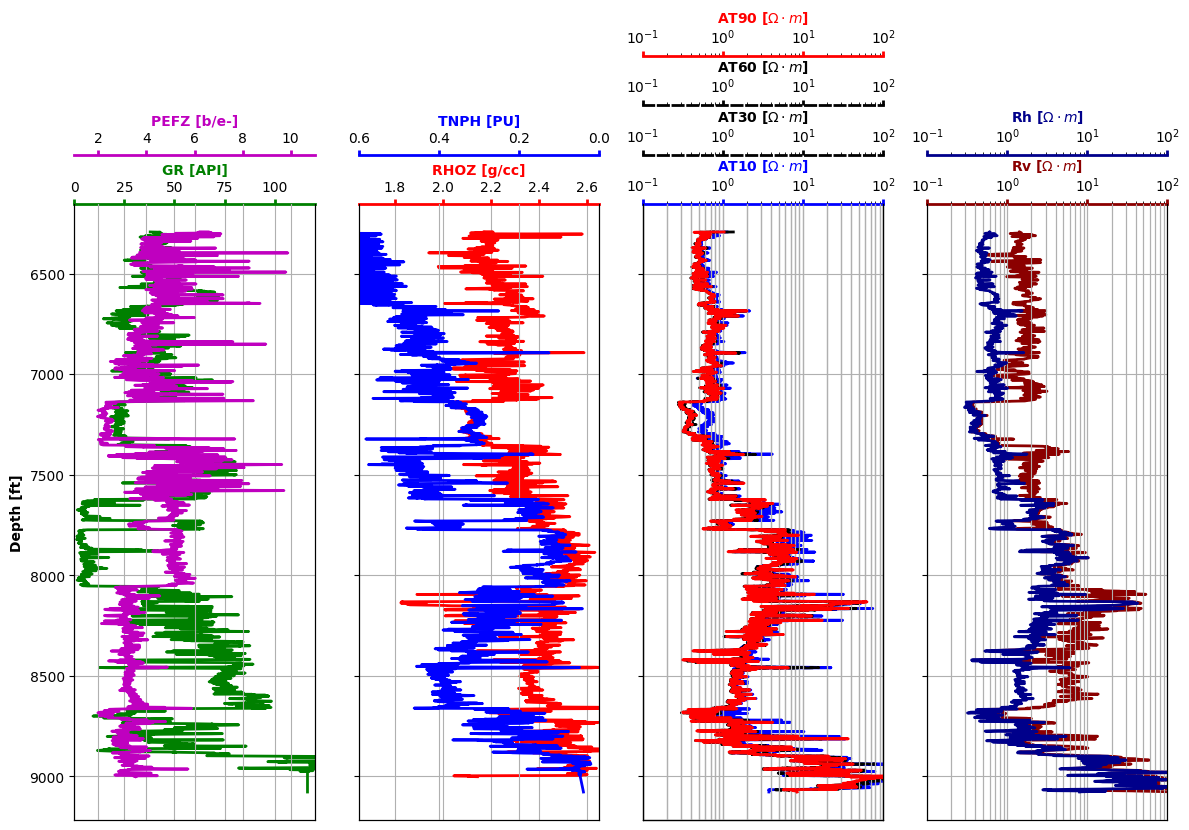

In [6]:
fig, axs = plt.subplots(1, 4, figsize=(12,8.5), sharey=True)
ax1, ax2, ax3, ax4 = axs

ax11 = ax1.twiny()
plot_curve(ax1, dpinn, 'GR', lb=0, ub=120, color='g', units='API')
plot_curve(ax11, field2_data, 'PEFZ', lb=1, ub=11, color='m', units='b/e-', pad=8)

ax21 = ax2.twiny()
plot_curve(ax2, field2_data, 'RHOZ', lb=1.65, ub=2.65, color='r', units='g/cc')
plot_curve(ax21, field2_data, 'TNPH', lb=0.6, ub=0, color='b', units='PU', pad=8)

ax31, ax32, ax33 = ax3.twiny(), ax3.twiny(), ax3.twiny()
plot_curve(ax3, field2_data, 'AT10', lb=0.1, ub=100, color='b', semilog=True, units='$\Omega\cdot m$')
plot_curve(ax31, field2_data, 'AT30', lb=0.1, ub=100, color='k', ls='--', semilog=True, units='$\Omega\cdot m$', pad=8)
plot_curve(ax32, field2_data, 'AT60', lb=0.1, ub=100, color='k', ls='--', semilog=True, units='$\Omega\cdot m$', pad=16)
plot_curve(ax33, field2_data, 'AT90', lb=0.1, ub=100, color='r', semilog=True, units='$\Omega\cdot m$', pad=24)

ax41 = ax4.twiny()
plot_curve(ax4, dpinn, 'Rv', lb=0.1, ub=100, color='darkred', units='$\Omega\cdot m$', semilog=True)
plot_curve(ax41, dpinn, 'Rh', lb=0.1, ub=100, color='darkblue', units='$\Omega\cdot m$', semilog=True, pad=8)

ax1.set_ylabel('Depth [ft]', weight='bold')
ax1.invert_yaxis()
plt.tight_layout()
plt.show()

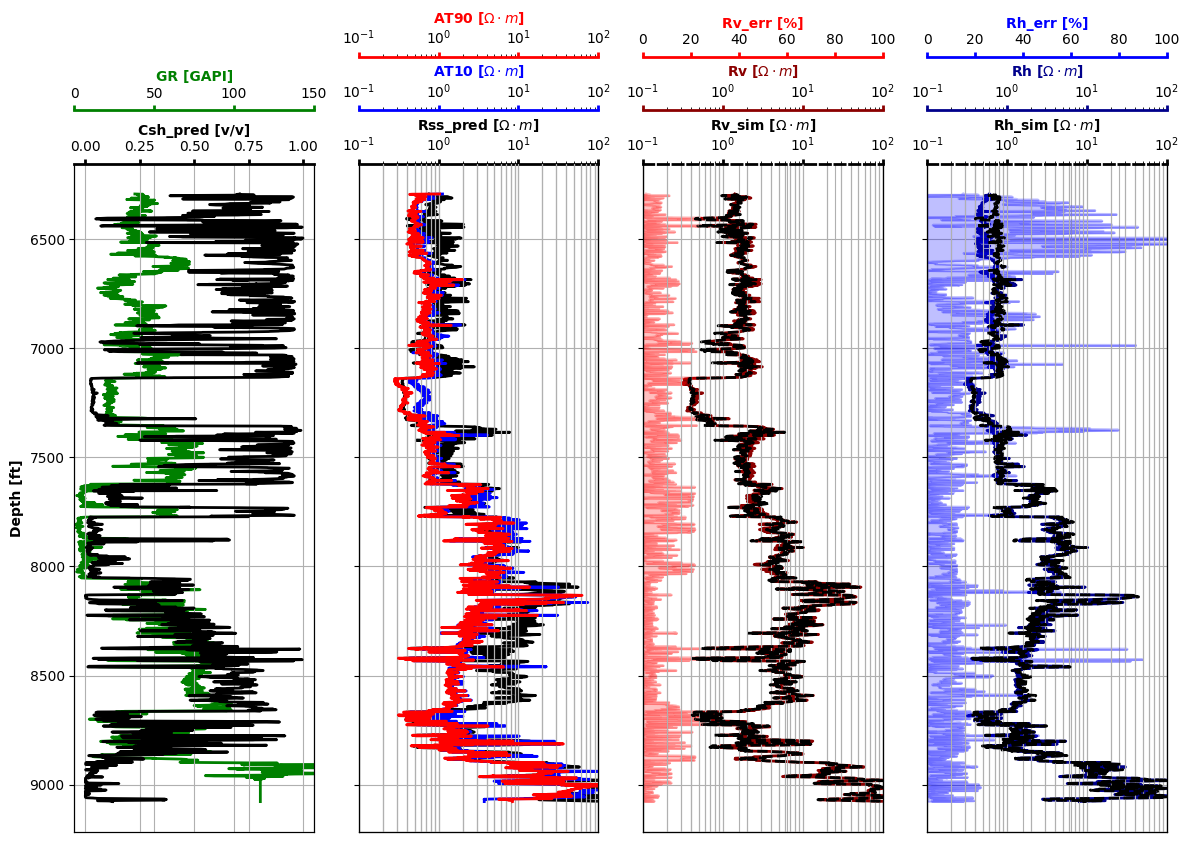

In [7]:
fig, axs = plt.subplots(1, 4, figsize=(12,8.5), sharey=True)
ax1, ax2, ax3, ax4 = axs

ax11 = ax1.twiny()
plot_curve(ax1, dpinn, 'GR', lb=0, ub=150, color='g', units='GAPI', pad=8)
plot_curve(ax11, dpinn, 'Csh_pred', lb=-0.05, ub=1.05, color='k', units='v/v')

ax21, ax22 = ax2.twiny(), ax2.twiny()
plot_curve(ax2, dpinn, 'Rss_pred', lb=0.1, ub=100, color='k', units='$\Omega\cdot m$', semilog=True)
plot_curve(ax21, dpinn, 'AT10', lb=0.1, ub=100, color='b', units='$\Omega\cdot m$', semilog=True, pad=8)
plot_curve(ax22, dpinn, 'AT90', lb=0.1, ub=100, color='r', units='$\Omega\cdot m$', semilog=True, pad=16)

ax31, ax32 = ax3.twiny(), ax3.twiny()
plot_curve(ax3, dpinn, 'Rv', lb=0.1, ub=100, color='darkred', units='$\Omega\cdot m$', semilog=True, pad=8)
plot_curve(ax31, dpinn, 'Rv_err', lb=0, ub=100, color='r', alpha=0.25, fill=True, units='%', pad=16)
plot_curve(ax32, dpinn, 'Rv_sim', lb=0.1, ub=100, color='k', ls='--', units='$\Omega\cdot m$', semilog=True)

ax41, ax42 = ax4.twiny(), ax4.twiny()
plot_curve(ax4, dpinn, 'Rh', lb=0.1, ub=100, color='darkblue', units='$\Omega\cdot m$', semilog=True, pad=8)
plot_curve(ax41, dpinn, 'Rh_err', lb=0, ub=100, color='b', alpha=0.25, fill=True, units='%', pad=16)
plot_curve(ax42, dpinn, 'Rh_sim', lb=0.1, ub=100, color='k', ls='--', units='$\Omega\cdot m$', semilog=True)

ax1.set_ylabel('Depth [ft]', weight='bold')
ax1.invert_yaxis()
plt.tight_layout()
plt.show()

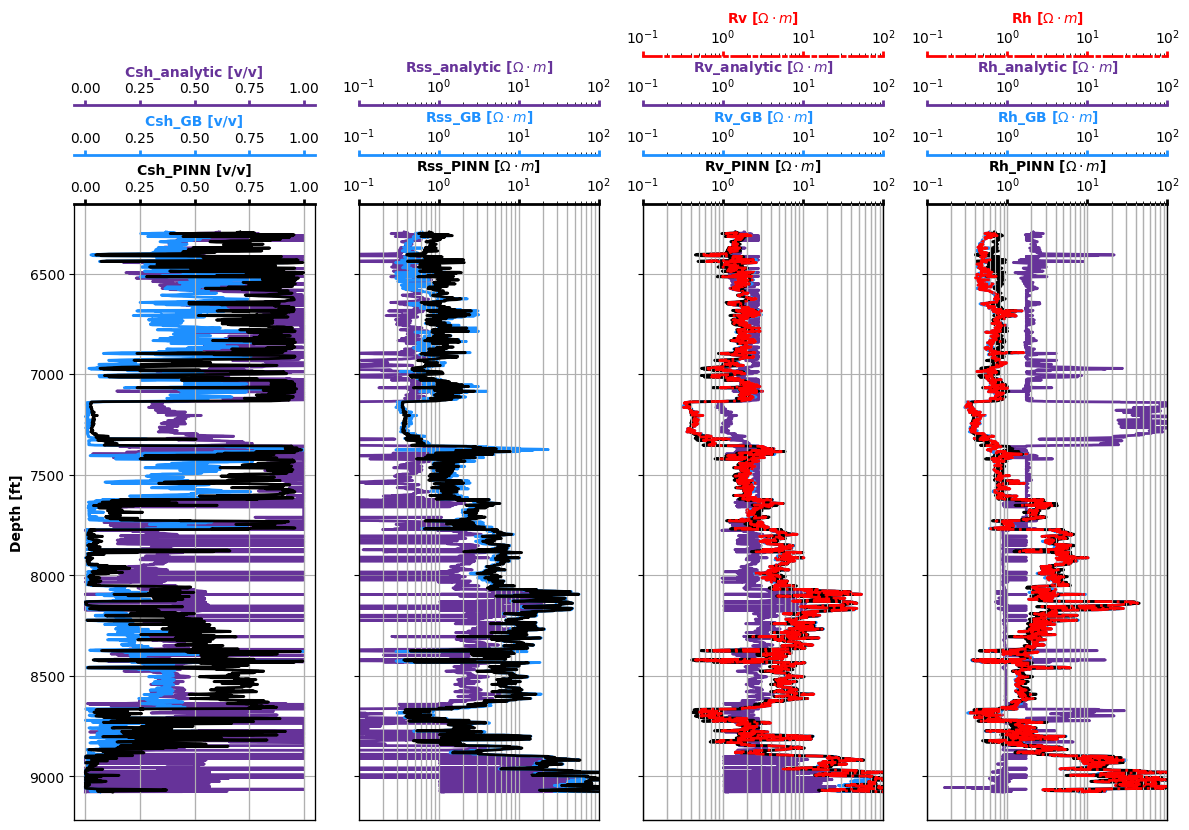

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(12,8.5), sharey=True)
ax1, ax2, ax3, ax4 = axs

ax11, ax12 = ax1.twiny(), ax1.twiny()
plot_curve(ax1, dpinn, 'Csh_q', lb=-0.05, ub=1.05, color='rebeccapurple', units='v/v', label='Csh_analytic', pad=16)
plot_curve(ax11, dgb, 'Csh_pred', lb=-0.05, ub=1.05, color='dodgerblue', units='v/v', label='Csh_GB', pad=8)
plot_curve(ax12, dpinn, 'Csh_pred', lb=-0.05, ub=1.05, color='k', units='v/v', label='Csh_PINN')

ax21, ax22 = ax2.twiny(), ax2.twiny()
plot_curve(ax2, dpinn, 'Rss_q', lb=0.1, ub=100, color='rebeccapurple', units='$\Omega\cdot m$', label='Rss_analytic', semilog=True, pad=16)
plot_curve(ax21, dgb, 'Rss_pred', lb=0.1, ub=100, color='dodgerblue', units='$\Omega\cdot m$', label='Rss_GB', semilog=True, pad=8)
plot_curve(ax22, dpinn, 'Rss_pred', lb=0.1, ub=100, color='k', units='$\Omega\cdot m$', label='Rss_PINN', semilog=True)

ax31, ax32, ax33 = ax3.twiny(), ax3.twiny(), ax3.twiny()
plot_curve(ax3, dpinn, 'Rv_sim_q', lb=0.1, ub=100, color='rebeccapurple', units='$\Omega\cdot m$', label='Rv_analytic', semilog=True, pad=16)
plot_curve(ax31, dgb, 'Rv_sim', lb=0.1, ub=100, color='dodgerblue', units='$\Omega\cdot m$', label='Rv_GB', semilog=True, pad=8)
plot_curve(ax32, dpinn, 'Rv_sim', lb=0.1, ub=100, color='k', units='$\Omega\cdot m$', label='Rv_PINN', semilog=True)
plot_curve(ax33, dpinn, 'Rv', lb=0.1, ub=100, color='r', units='$\Omega\cdot m$', ls='-.', semilog=True, pad=24)

ax41, ax42, ax43 = ax4.twiny(), ax4.twiny(), ax4.twiny()
plot_curve(ax4, dpinn, 'Rh_sim_q', lb=0.1, ub=100, color='rebeccapurple', units='$\Omega\cdot m$', label='Rh_analytic', semilog=True, pad=16)
plot_curve(ax41, dgb, 'Rh_sim', lb=0.1, ub=100, color='dodgerblue', units='$\Omega\cdot m$', label='Rh_GB', semilog=True, pad=8)
plot_curve(ax42, dpinn, 'Rh_sim', lb=0.1, ub=100, color='k', units='$\Omega\cdot m$', label='Rh_PINN', semilog=True)
plot_curve(ax43, dpinn, 'Rh', lb=0.1, ub=100, color='r', units='$\Omega\cdot m$', ls='-.', semilog=True, pad=24)

ax1.set_ylabel('Depth [ft]', weight='bold')
ax1.invert_yaxis()
plt.tight_layout()
plt.show()

In [9]:
df = field2_results

error_metrics(df)
print('-'*45)
error_metrics(synth1_gb_results)
print('-'*45)
mse_rv = mean_squared_error(df['Rv'], df['Rv_sim_q'])
mse_rh = mean_squared_error(df['Rh'], df['Rh_sim_q'])
r2_rv = r2_score(df['Rv'], df['Rv_sim_q'])*100
r2_rh = r2_score(df['Rh'], df['Rh_sim_q'])*100
sterr_rv = np.mean(np.abs(df['Rv']-df['Rv_sim_q'])) / np.std(np.abs(df['Rv']-df['Rv_sim_q']))
sterr_rh = np.mean(np.abs(df['Rh']-df['Rh_sim_q'])) / np.std(np.abs(df['Rh']-df['Rh_sim_q']))
mape_rv = mean_absolute_percentage_error(df['Rv'], df['Rv_sim_q']) * 100
mape_rh = mean_absolute_percentage_error(df['Rh'], df['Rh_sim_q']) * 100
print('Mean Squared Error - Rv: {:.4f}  | Rh: {:.4f}'.format(mse_rv, mse_rh))
print('R2 Score           - Rv: {:.3f}  | Rh: {:.3f}'.format(r2_rv, r2_rh))
print('Standard Error     - Rv: {:.4f}  | Rh: {:.4f}'.format(sterr_rv, sterr_rh))
print('MAPE               - Rv: {:.3f}%  | Rh: {:.3f}%'.format(mape_rv, mape_rh))

Mean Squared Error - Rv: 0.3330  | Rh: 0.7055
R2 Score           - Rv: 99.843  | Rh: 99.407
Standard Error     - Rv: 0.5438  | Rh: 0.4256
MAPE               - Rv: 6.396%  | Rh: 15.724%
---------------------------------------------
Mean Squared Error - Rv: 0.0028  | Rh: 0.0029
R2 Score           - Rv: 99.983  | Rh: 99.987
Standard Error     - Rv: 0.3216  | Rh: 0.3216
MAPE               - Rv: 0.149%  | Rh: 0.147%
---------------------------------------------
Mean Squared Error - Rv: 199.1941  | Rh: 1529.5008
R2 Score           - Rv: 6.288  | Rh: -1185.352
Standard Error     - Rv: 0.3735  | Rh: 0.2260
MAPE               - Rv: 58.544%  | Rh: 1369.551%


***
# END

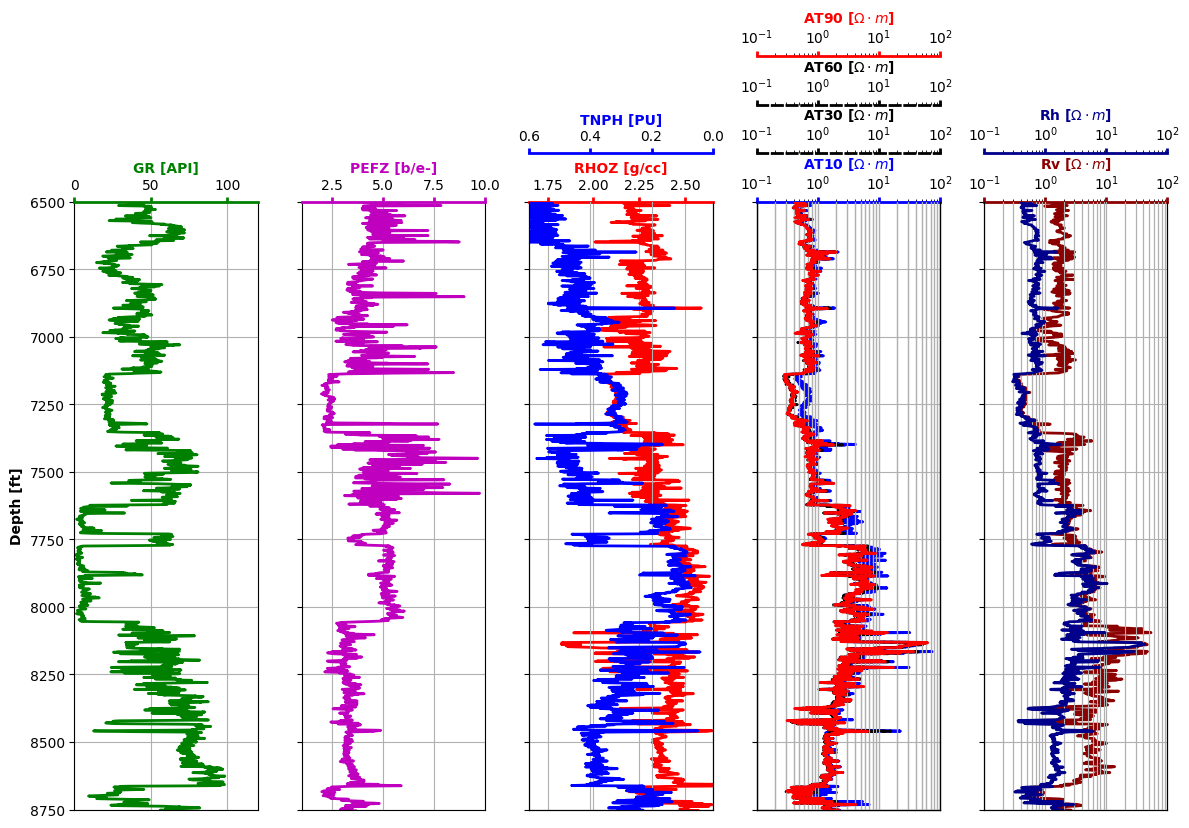

In [15]:
fig, axs = plt.subplots(1, 5, figsize=(12,8.5), sharey=True)
ax1, ax2, ax3, ax4, ax5 = axs

plot_curve(ax1, dpinn, 'GR', lb=0, ub=120, color='g', units='API')

plot_curve(ax2, field2_data, 'PEFZ', lb=1, ub=10, color='m', units='b/e-')

ax31 = ax3.twiny()
plot_curve(ax3, field2_data, 'RHOZ', lb=1.65, ub=2.65, color='r', units='g/cc')
plot_curve(ax31, field2_data, 'TNPH', lb=0.6, ub=0, color='b', units='PU', pad=8)

ax41, ax42, ax43 = ax4.twiny(), ax4.twiny(), ax4.twiny()
plot_curve(ax4, field2_data, 'AT10', lb=0.1, ub=100, color='b', semilog=True, units='$\Omega\cdot m$')
plot_curve(ax41, field2_data, 'AT30', lb=0.1, ub=100, color='k', ls='--', semilog=True, units='$\Omega\cdot m$', pad=8)
plot_curve(ax42, field2_data, 'AT60', lb=0.1, ub=100, color='k', ls='--', semilog=True, units='$\Omega\cdot m$', pad=16)
plot_curve(ax43, field2_data, 'AT90', lb=0.1, ub=100, color='r', semilog=True, units='$\Omega\cdot m$', pad=24)

ax51 = ax5.twiny()
plot_curve(ax5, dpinn, 'Rv', lb=0.1, ub=100, color='darkred', units='$\Omega\cdot m$', semilog=True)
plot_curve(ax51, dpinn, 'Rh', lb=0.1, ub=100, color='darkblue', units='$\Omega\cdot m$', semilog=True, pad=8)

ax1.set_ylabel('Depth [ft]', weight='bold')
ax1.set_ylim(6500,8750)
ax1.invert_yaxis()
plt.tight_layout()
plt.show()

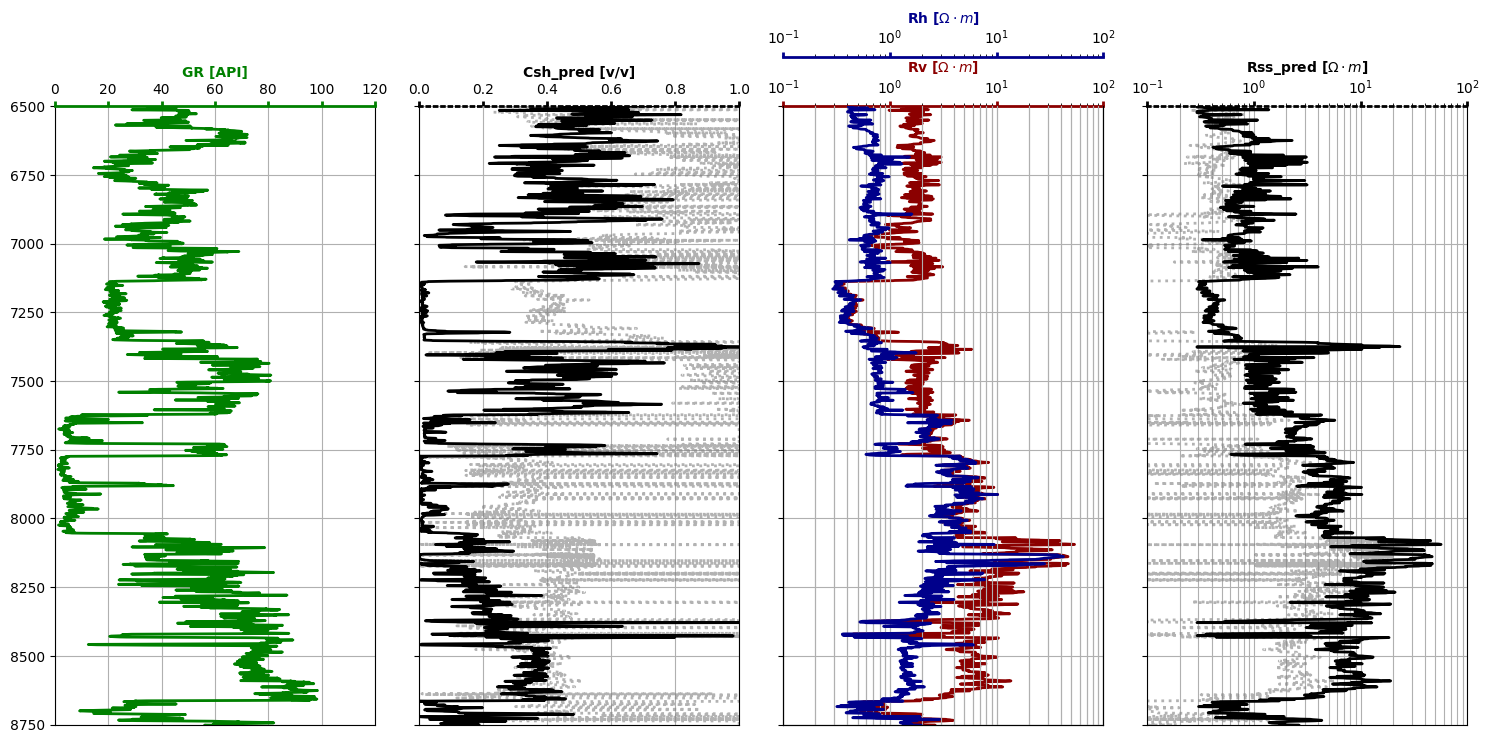

In [63]:

fig, axs = plt.subplots(1, 4, figsize=(15,7.5), sharey=True)
ax1, ax2, ax3, ax4 = axs

plot_curve(ax1, dpinn, 'GR', lb=0, ub=120, color='g', units='API')


plot_curve(ax2, dpinn, 'Csh_q', lb=0, ub=1, color='gray', units='v/v', ls=':', alpha=0.6)
plot_curve(ax2, dgb, 'Csh_pred', lb=0, ub=1, color='k', units='v/v')


ax31 = ax3.twiny()
plot_curve(ax3, dpinn, 'Rv', lb=0.1, ub=100, color='darkred', units='$\Omega\cdot m$', semilog=True)
plot_curve(ax31, dpinn, 'Rh', lb=0.1, ub=100, color='darkblue', units='$\Omega\cdot m$', semilog=True, pad=8)

plot_curve(ax4, dpinn, 'Rss_q', lb=0.1, ub=100, color='gray', units='$\Omega\cdot m$',  ls=':', semilog=True, alpha=0.6)
plot_curve(ax4, dgb, 'Rss_pred', lb=0.1, ub=100, color='k', units='$\Omega\cdot m$', semilog=True)

ax1.set_ylim(6500,8750)
ax1.invert_yaxis()
plt.tight_layout()
plt.show()